In [1]:
from google.colab import drive
drive.mount("/drive", force_remount=True)

import locale
locale.getpreferredencoding = lambda: "UTF-8"

Mounted at /drive


In [2]:
%%shell
rm -rf fdd
git clone https://github.com/Davidvandijcke/fdd.git

Cloning into 'fdd'...
remote: Enumerating objects: 721, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 721 (delta 33), reused 57 (delta 24), pack-reused 650
Receiving objects: 100% (721/721), 6.64 MiB | 19.66 MiB/s, done.
Resolving deltas: 100% (476/476), done.


In [3]:
import os
os.chdir("./fdd")


In [4]:
!pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/fdd
  Preparing metadata (setup.py) ... done
  Created wheel for FDD: filename=FDD-0.1-py3-none-any.whl size=59533 sha256=5b4a7cd314e649cbeb756441f1b793bce747251adf802b16d20c8749b9177f0f
  Stored in directory: /tmp/pip-ephem-wheel-cache-gar8x5jx/wheels/fe/c5/16/92a65daa3b6f33622ef7607b5b092fc9c020e86570dbc20573
Successfully built FDD
  Attempting uninstall: FDD
    Found existing installation: FDD 0.1
    Uninstalling FDD-0.1:
      Successfully uninstalled FDD-0.1


In [5]:
%load_ext autoreload
%autoreload 2
from FDD import FDD
from FDD.SURE import SURE
import numpy as np
import pandas as pd
import torch 
from matplotlib import pyplot as plt
import ray


In [6]:
def f(x,y, jsize):
  temp = np.sqrt((x-1/2)**2 + (y-1/2)**2)
  if temp < 1/4:
      return temp
  else:
      return temp + jsize

def generate2D(jsize=0.1, sigma = 0.02, N=500):
  data = np.random.rand(N, 2) # draw 1000 2D points from a uniform

  # now sample the function values on the data points
  grid_sample = np.zeros((data.shape[0],1))
  grid_f = np.zeros((data.shape[0],1))
  for i in range(data.shape[0]):
      grid_f[i] = f(data[i,0], data[i,1], jsize)
      grid_sample[i] = grid_f[i] + np.random.normal(loc = 0, scale = sigma) # add random Gaussian noise
  
  # now cast this data into a standard data format
  X = data.copy()
  Y = grid_sample.copy().flatten()
  u = grid_f.copy().flatten()

  return (X,Y,u)

# Simulations

In [ ]:
#-------------
# parameters
#-------------
jsize = 0.095
N = 50000
S = 16
sigma = 0.02

# parameters that work
# jsize = 0.1, nu = 0.01, lambda = 10, N = 1000, S = 16

# Generate some random data points from a discontinuous function
np.random.seed(0)
data = np.random.rand(N, 2) # draw 1000 2D points from a uniform

# Create the grid
# Define the grid dimensions and resolution
xmin, xmax = 0, 1
ymin, ymax = 0, 1
resolution = 0.01 # 100 by 100 grid
x, y = np.meshgrid(np.arange(xmin, xmax, resolution), np.arange(ymin, ymax, resolution))
grid = np.dstack((x, y))
grid_f = np.zeros(grid.shape[:2])


# Compute the function values on the grid
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        grid_f[i, j] = f(grid[i, j][0], grid[i, j][1], jsize)
        
X, Y = generate2D(jsize, sigma, N)

In [ ]:
# and run the FDD command
# jsize = 0.1
# N = 5000
# S = 16
# lmbda = 40, nu = 0.01
resolution = 1/int(np.sqrt(N*2/3))
model = FDD(Y, X, level = S, lmbda = 1, nu = 0.01, iter = 10000, tol = 5e-5, pick_nu = "MS", resolution = resolution)
u, jumps, J_grid, nrj, eps, it = model.run()

temp = pd.DataFrame(jumps)
temp[['alpha', 'N', 'S']] = jsize, N, S

In [ ]:
temp['Y_jumpsize'].abs().mean()


In [ ]:
plt.imshow(J_grid, origin = "lower")
plt.show()
#?plt.savefig("/drive/MyDrive/fdd/pointcloud.pdf", bbox_inches = "tight")

In [ ]:
plt.figure(figsize=(5,5))
test = temp[temp['Y_jumpsize'].between(-0.01,0.01)]
plt.scatter(test['X_0'], test['X_1'])
plt.xlim(0,1)
plt.ylim(0,1)

In [ ]:
plt.figure()
plt.scatter(data[:, 0], data[:, 1], c=grid_sample,  s=10, edgecolors='none')
#plt.show()
plt.savefig("/drive/MyDrive/fdd/pointcloud_raw.pdf",  bbox_inches = "tight")

In [ ]:
plt.imshow(grid_f)
plt.savefig("/drive/MyDrive/fdd/pointcloud_og.pdf",  bbox_inches = "tight")

Now, we run the Monte Carlo Simulations.

In [ ]:
np.random.seed(0)


#-------------
# parameters
#-------------
N_list = [100, 500, 1000]
N_sure = max(N_list)
S = 16
num_samples = 500
R = 5
num_gpus = 1
num_cpus = 8

@ray.remote(num_gpus=num_gpus, num_cpus=num_cpus)  # This decorator indicates that this function will be distributed, with each task using one GPU.
def train(config, jsize, sigma, N, lmbda, nu, S):
    # Here we randomly generate training data.
    X, Y, U = generate2D(jsize=jsize, sigma=sigma, N=N)

    if torch.cuda.is_available(): # cuda gpus
        device_id = torch.cuda.current_device() 
        device = torch.device("cuda:{}".format(device_id)) 
        torch.cuda.set_device(device)

    elif torch.backends.mps.is_available(): # mac gpus
        device = torch.device("mps")
        
    resolution = 1/int(np.sqrt(N*2/3))
    model = FDD(Y, X, level = S, lmbda = lmbda, nu = nu, iter = 5000, tol = 5e-5, resolution=resolution,
            pick_nu = "MS", scaled = True, scripted = False)
    
    u, jumps, J_grid, nrj, eps, it = model.run()

    temp = pd.DataFrame(jumps)
    temp[['alpha', 'N', 'S',  'sigma', 'lambda', 'nu']] = jsize, N, S, sigma, lmbda, nu
    return temp

 
dflist = []

for sigma in [0.01, 0.05]:
  for jsize in [0.1, 0.2, 0.5]:

    # run SURE once for largest N
    X, Y, U = generate2D(jsize, sigma=sigma, N=N_sure)
    resolution = 1/int(np.sqrt(N_sure*2/3))
    model = FDD(Y, X, level = S, lmbda = 20, nu = 0.01, iter = 10000, tol = 5e-5, resolution=resolution, pick_nu = "MS")
    res = SURE(tuner=True, num_samples=num_samples, model=model, R=R, 
               num_gpus=num_gpus, num_cpus=num_cpus)
    best = res.get_best_result(metric = "score", mode = "min")

    config = best.metrics['config']
    lmbda, nu = config['lmbda'], config['nu']

    sims = range(100)  # 100 simulations
    results = ray.get([train.remote(config, jsize, sigma, N, lmbda, nu, S) for config, N in zip(sims, N_list)])

    temp = pd.concat(results)
    dflist.append(temp)

    # # run monte carlo simulations for given jump size
    # for N in N_list:
    #     for s in range(100): # 100 simulations

    #       # and run the FDD command
    #       X, Y = generate2D(jsize, sigma=sigma, N=N_sure)
    #       resolution = 1/int(np.sqrt(N*2/3))
    #       model = FDD(Y, X, level = S, lmbda = lmbda, nu = nu, iter = 10000, tol = 5e-5, resolution=resolution, pick_nu = "MS")
    #       u, jumps, J_grid, nrj, eps, it = model.run()

    #       temp = pd.DataFrame(jumps)
    #       temp[['alpha', 'N', 'S', 's', 'sigma']] = jsize, N, S, s, sigma

    #       dflist.append(temp)


In [25]:
total = pd.concat(dflist)

In [40]:
total[(total.alpha == 0.1) & (total.N == 1000)]['Y_jumpsize'].abs().mean()

0.04949271201385167

In [ ]:
# test Ray MC

configurations = [{"lr": 1} for _ in range(10)]  # Generate configurations for 10 models.

@ray.remote(num_gpus=1, num_cpus=4)  # This decorator indicates that this function will be distributed, with each task using one GPU.
def train(config, jsize, sigma, N, lmbda, nu, S):
    # Here we randomly generate training data.
    X, Y, U = generate2D(jsize=jsize, sigma=sigma, N=N)

    if torch.cuda.is_available(): # cuda gpus
        device_id = torch.cuda.current_device() 
        device = torch.device("cuda:{}".format(device_id)) 
        torch.cuda.set_device(device)

    elif torch.backends.mps.is_available(): # mac gpus
        device = torch.device("mps")
        
    resolution = 1/int(np.sqrt(N*2/3))
    model = FDD(Y, X, level = S, lmbda = lmbda, nu = nu, iter = 5000, tol = 5e-5, resolution=resolution,
            pick_nu = "MS", scaled = True, scripted = False)
    
    u, jumps, J_grid, nrj, eps, it = model.run()

    temp = pd.DataFrame(jumps)
    temp[['alpha', 'N', 'S',  'sigma']] = jsize, N, S, sigma
    return temp

jsize = 0.15
sigma = 0.02
N = 500
lmbda = 10
nu = 0.01
S = 16
results = ray.get([train.remote(config, jsize, sigma, N, lmbda, nu, S) for config in configurations])



In [18]:
hello = pd.concat(results)
hello

X_0       X_1  Y_jumpfrom  Y_jumpto  Y_jumpsize  alpha    N   S  \
0   0.207431  0.097978    0.726459  0.643852   -0.082607   0.15  500  16   
1   0.100013  0.148832    0.773116  0.681116   -0.092000   0.15  500  16   
2   0.708266  0.162241    0.612210  0.577019   -0.035192   0.15  500  16   
3   0.119058  0.186630    0.724872  0.648697   -0.076176   0.15  500  16   
4   0.566602  0.209755    0.492405  0.497959    0.005554   0.15  500  16   
..       ...       ...         ...       ...         ...    ...  ...  ..   
36  0.579792  0.722424    0.163394  0.484315    0.320921   0.15  500  16   
37  0.764833  0.703414    0.300491  0.568085    0.267594   0.15  500  16   
38  0.866333  0.717960    0.565506  0.625964    0.060458   0.15  500  16   
39  0.642878  0.777159    0.492278  0.538274    0.045996   0.15  500  16   
40  0.715730  0.765216    0.292416  0.577742    0.285326   0.15  500  16   

    sigma  
0    0.02  
1    0.02  
2    0.02  
3    0.02  
4    0.02  
..    ...  
36   0.02  
37   0.02  
38   0.02  
39   0.02  
40   0.02  

[438 rows x 9 columns]

In [14]:
jsize = 0.15
sigma = 0.02
N = 500
lmbda = 10
nu = 0.01
S = 16
X, Y, U = generate2D(jsize, sigma, N)
resolution = 1/int(np.sqrt(N*2/3))
model = FDD(Y, X, level = S, lmbda = lmbda, nu = nu, iter = 5000, tol = 5e-5, resolution=resolution,
        pick_nu = "MS", scaled = True, scripted = False)

u, jumps, J_grid, nrj, eps, it = model.run()
temp = pd.DataFrame(jumps)
temp[['alpha', 'N', 'S', 'sigma']] = jsize, N, S, sigma

/usr/local/lib/python3.10/dist-packages/FDD/primaldual_multi_scaled_tune.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tauu = torch.tensor(  1.0 / torch.sqrt(denom) * res, device=dev)  # torch.tensor(  1.0 / 6.0 * res, device=dev) # *res
/usr/local/lib/python3.10/dist-packages/FDD/primaldual_multi_scaled_tune.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigmap = torch.tensor( 1.0 / torch.sqrt(denom)  * res, device=dev) # torch.tensor( (1.0 / (3.0 + l))  * res, device=dev) # *res
(train pid=24212)   tauu = torch.tensor(  1.0 / torch.sqrt(denom) * res, device=dev)  # torch.tensor(  1.0 / 6.0 * res, device=dev) # *res
(train pid=24212)   sigmap = torch.tensor( 1.0 / torch.sqr

In [9]:
U.shape

(500,)

In [21]:
X.shape

(500,)

In [ ]:
df = pd.concat(dflist)
df.to_csv('/drive/MyDrive/fdd/simulations_01_nonscaled.csv')

In [ ]:
# create a table from the simulations
df[(df.s == 5) & (df.N == 500)].shape


(46, 10)

In [ ]:
df = pd.read_csv('/drive/MyDrive/fdd/simulations.csv')
df1 = pd.read_csv('/drive/MyDrive/fdd/simulations_10K.csv')
df = pd.concat([df, df1])



In [ ]:
df.head()

Unnamed: 0       X_0       X_1  Y_jumpfrom  Y_jumpto  Y_jumpsize  alpha  \
0           0  0.233361  0.098583    0.521584  0.472890   -0.048694   0.01   
1           1  0.561813  0.143152    0.489094  0.346343   -0.142751   0.01   
2           2  0.918559  0.079776    0.551036  0.605675    0.054639   0.01   
3           3  0.504816  0.229158    0.241618  0.346343    0.104725   0.01   
4           4  0.921739  0.276251    0.548899  0.460034   -0.088865   0.01   

     N   S  s  
0  100  16  0  
1  100  16  0  
2  100  16  0  
3  100  16  0  
4  100  16  0

In [ ]:
# Group by 'alpha', 'N', and 'S' and calculate the mean 'Y_jumpsize'
df = pd.read_csv('/drive/MyDrive/fdd/simulations_01_10K.csv')
df['Y_jumpsize'] = df['Y_jumpsize'].abs()
mean_jumpsize = df.groupby(['alpha', 'N', 'S', 's'])['Y_jumpsize'].mean().reset_index()
mean_jumpsize = mean_jumpsize.groupby(['alpha', 'N', 'S'])['Y_jumpsize'].mean().reset_index()

# Create a new column 'N_S' that combines 'N' and 'S' as a tuple
#?mean_jumpsize['N_S'] = mean_jumpsize.apply(lambda row: f"{row['N']}_{row['S']}", axis=1)

# Create the pivot table with 'alpha' as rows and 'N_S' as columns
pivot_table = mean_jumpsize.pivot_table(index='alpha', columns='N', values='Y_jumpsize')

# Optional: sort the index and columns if needed
pivot_table = pivot_table.sort_index(axis=0).sort_index(axis=1)

# Display the pivot table
print(pivot_table)

FileNotFoundError: ignored

In [ ]:
 pivot_table.reindex(sorted(pivot_table.columns), axis=1)

N_S    100.0_16.0  1000.0_16.0  200.0_16.0  500.0_16.0
alpha                                                 
0.093    0.131267     0.093341    0.119853    0.097023

### Test SURE

In [11]:
#-------------
# parameters
#-------------
jsize = 0.2
N = 500
S = 16
sigma = 0.02

# parameters that work
# jsize = 0.1, nu = 0.01, lambda = 10, N = 1000, S = 16

# Generate some random data points from a discontinuous function
np.random.seed(34088)

X,Y = generate2D(jsize, sigma, N)

In [12]:
# and run the FDD command
# jsize = 0.1
# N = 5000
# S = 16
# lmbda = 40, nu = 0.01
resolution = 1/int(np.sqrt(2/3*N))
model = FDD(Y, X, level = S, lmbda = 1, nu = 0.01, iter = 10000, tol = 5e-5, pick_nu = "MS", resolution = resolution, scaled = False)

In [ ]:
import time

model.lmbda = 1
model.nu = 0.005
t0 = time.time()
res = SURE(tuner = True, num_samples = 20, model=model)
print(time.time()-t0)

In [15]:
test = res.get_best_result(metric = "score", mode = "min")


In [25]:
test.metrics['config']

{'lmbda': 12.20487381380366, 'nu': 0.005884878356001899}

In [ ]:
import pickle
with open('/drive/MyDrive/fdd/data.pickle', 'wb') as f:
    pickle.dump(res, f)

In [ ]:
import pickle
with open('/drive/MyDrive/fdd/data.pickle', 'rb') as f:
     pkl = pickle.load(f)

In [ ]:
df = pd.DataFrame({"lambda_sure" : [res['x'][0]], "nu_sure" : [res['x'][1]]})
df.to_csv('/drive/MyDrive/fdd/SURE_circle_fuckkk.csv')

In [ ]:
df = pd.read_csv('/drive/MyDrive/fdd/SURE_circle_fuckkk.csv')



In [ ]:

import pdb
from types import MethodType
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
import pywt

def gridSearch(self, args):
    lmbda_list = [1, 5, 10, 20, 50, 100,  500]
    nu_list = [0.001, 0.005, 0.01,  0.05, 0.1,0.5,1]

    objlist = []
    arglist = []

    for lmbda in lmbda_list:
        for nu in nu_list:
            # perform a grid search on the SURE_objective, retain all the values
            # and then pick the best one
            theta = np.array([lmbda, nu])
            objlist.append(self.SURE_objective(theta, *args))
            arglist.append((lmbda, nu))
    
    # get index of minimum value
    min_idx = np.argmin(objlist)
    
    # get args of minimum value
    best_args = arglist[min_idx]
    
    return best_args

def SURE(self, maxiter = 100, R = 1, grid = True):

    sigma_sq = self.waveletDenoising(self.grid_y)
    N = self.grid_y.size
    y = self.grid_y.squeeze()
    y_diff = self.forward_differences(y, D = len(y.shape)) / self.resolution
    y_norm = np.linalg.norm(np.linalg.norm(y_diff, ord = 2, axis = 0)**2)**2

    beta = N * sigma_sq / (4 * y_norm)
    lambda_0 = 1 # 1/(beta)
    nu_0 = 0.005 # (sigma_sq / 8) / beta

    f, repeats, level, lmbda, nu, tol = \
        self.arraysToTensors(self.grid_y, self.iter, self.level, lambda_0, nu_0, self.tol)
    
    #self.SURE_objective(self.lmbda, self.nu, tol, self.eps, f, repeats, level, self.grid_y, sigma_sq)

    b = torch.randn(list(f.shape) + [R], device = self.device) 

    if self.scaled:
      nu_max = y_diff.max() / self.resolution
    else:
      nu_max = 1

    if not grid:
        res = \
            minimize(self.SURE_objective, np.array([self.lmbda, self.nu]), 
                    tuple([tol, self.eps, f, repeats, level, self.grid_y, sigma_sq, b, R]),
                    method = "BFGS", tol = 1*10**(-9), 
                    options = {'disp' : True, 'maxiter' : maxiter})# , bounds = ((0, 500), (0, 1)))
        # bounds = [(0, 10), (0, 1)] # set bounds for your parameters
        # res = differential_evolution(self.SURE_objective, bounds,
        #             args=(tol, self.eps, f, repeats, level, self.grid_y, sigma_sq, b, R),
        #             maxiter=maxiter, disp=True, polish=True)
    else:
        res = self.gridSearch(tuple([tol, self.eps, f, repeats, level, self.grid_y, sigma_sq, b]))
        
    return res

def SURE_objective(self, theta, tol, eps, f, repeats, level, grid_y, sigma_sq, b, R=5):
  sure = []

  lmbda_torch = torch.tensor(theta[0], device = self.device, dtype = torch.float32)
  nu_torch = torch.tensor(theta[1], device = self.device, dtype = torch.float32)
  n = grid_y.size # flatten().shape[0]
  v = self.model(f, repeats, level, lmbda_torch, nu_torch, tol)[0]
  u = self.isosurface(v.cpu().detach().numpy())

  u_dist = np.mean(np.abs(grid_y.flatten() - u.flatten())**2)

  for r in range(R):
    
    bt = b[...,r]
    f_eps = f + bt * eps
    f_eps = torch.clamp(f_eps, min = 0, max = 1)
    
    v_eps = self.model(f_eps, repeats, level, lmbda_torch, nu_torch, tol)[0]
    u_eps = self.isosurface(v_eps.cpu().detach().numpy())
            
    divf_y = np.real(np.vdot(bt.cpu().detach().numpy().squeeze().flatten(), 
                              u_eps.flatten() - u.flatten())) / (eps)
    sure.append(u_dist - sigma_sq + 2 * sigma_sq * divf_y / n)
    # TODO: should be euclidean norm
  sure = np.mean(sure)

  return sure

def boundary(self, u):
    if not self.scaled:
        u_diff = self.forward_differences(u.copy(), D = len(u.shape)) / self.resolution # scale FD by side length
    else:
        u_diff = self.forward_differences(u, D = len(u.shape)) / self.resolution
    u_norm = np.linalg.norm(u_diff, axis = 0, ord = 2) # 2-norm

    if self.pick_nu == "kmeans":
        nu = self.pickKMeans(u_norm)
    else:
        nu = np.sqrt(self.nu)
    
    # find the boundary on the grid by comparing the gradient norm to the threshold
    J_grid = (u_norm >= nu).astype(int)

    ## find the boundary on the point cloud
    jumps = self.boundaryGridToData(J_grid, u)

    return (J_grid, jumps)

def waveletDenoising(self, y):
    
    coeffs = pywt.wavedecn(y.squeeze(), self.wavelet)
    
    # Get detail coefficients at the finest scale
    details = coeffs[-1]

    
    wavs = []  
    for key in details.keys():
        # Flatten the array to 1D for MAD calculation
        coeff_arr = np.ravel(details[key])
        wavs.append(coeff_arr)
    wavs = np.concatenate(wavs)
    
    mad = np.median(np.abs(wavs - np.median(wavs)))
    
    sigma = mad / 0.6745
    
    return sigma**2
        

model.SURE = MethodType(SURE, model)
model.SURE_objective = MethodType(SURE_objective, model)
model.gridSearch = MethodType(gridSearch, model)
model.boundary = MethodType(boundary, model)
model.waveletDenoising = MethodType(waveletDenoising, model)

model.eps = 0.01

In [ ]:
#lambda_sure, nu_sure = res['x']
lambda_sure, nu_sure = pkl
resolution = 1/int(np.sqrt(2/3*N))
model = FDD(Y, X, level = S, lmbda = 100, nu = 0.1, iter = 10000, tol = 5e-7, pick_nu = "MS", resolution = resolution, scaled = True)
model.lmbda = lambda_sure # df['lambda_sure'][0]
model.nu = nu_sure #df['nu_sure'][0]

u, jumps, J_grid, nrj, eps, it = model.run()

In [ ]:
model.pick_nu = "MS"
J_grid, jumps = model.boundary(u)

In [ ]:
plt.imshow(u)
plt.show()


NameError: ignored

In [ ]:
temp = pd.DataFrame(jumps)
temp['Y_jumpsize'].abs().mean()


0.15184413210121014

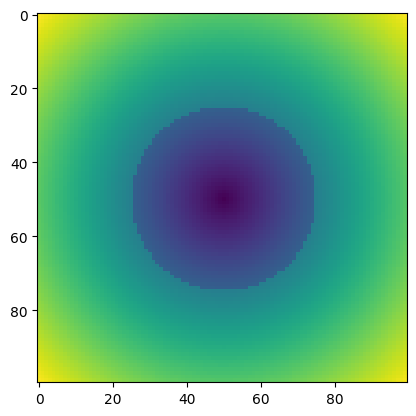

In [ ]:
plt.imshow(grid_f)

### More stuff

The function values, plotted as an image, look like this:

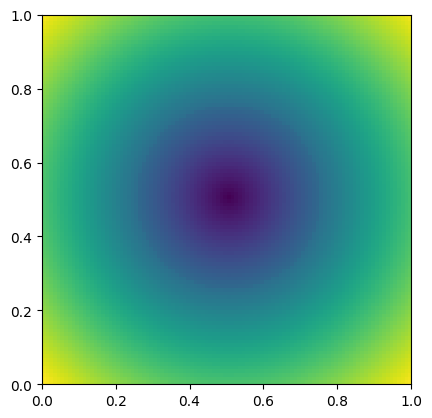

In [ ]:
# Plot the function values on the grid
plt.imshow(grid_f, extent=(xmin, xmax, ymin, ymax), origin='lower')
plt.show()

As a surface, it looks like this:

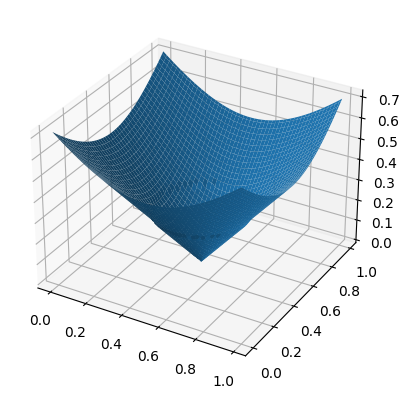

In [ ]:
# plot it as a surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, grid_f)
plt.show()

The sampled function values look like this:

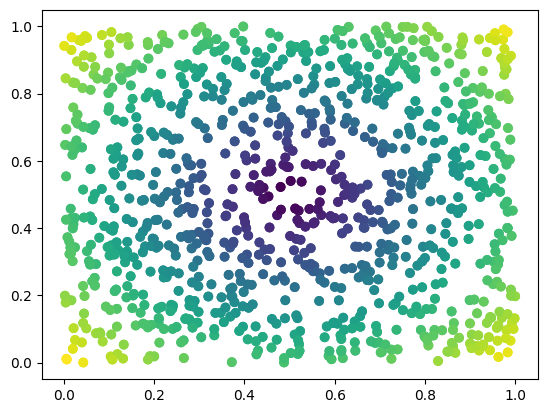

In [ ]:
# plot the sampled function values
plt.scatter(data[:, 0], data[:, 1], c=grid_sample,  s=50, edgecolors='none')
plt.show()

In [ ]:
# now cast this data into a standard data format
X = data.copy()
Y = grid_sample.copy().flatten()

# and run the FDD command
model = FDD(Y, X, level = 32, lmbda = 1, nu = 0.2, iter = 1000, tol = 5e-5)
u, jumps, J_grid, nrj, eps, it = model.run()


In [ ]:
np.absolute(jumps['Y_jumpsize'])

4.441319371839558e-05

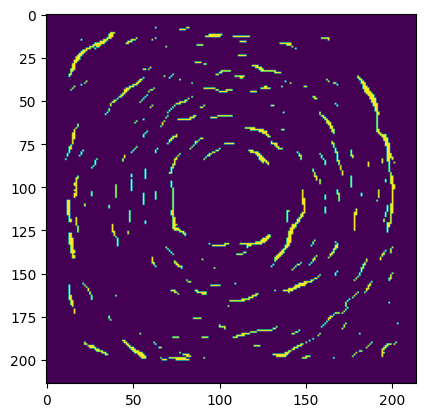

In [ ]:
plt.imshow(J_grid)
plt.show()

In [ ]:
J_grid

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

# Dell Replication

In [ ]:
%%shell
pip install geopandas folium matplotlib mapclassify contextily rasterio scikit-image geocube pandas #==2.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import geopandas as gpd
import contextily as cx


In [ ]:
# individual-level data
cons = pd.read_stata("/drive/MyDrive/fdd/dell/height.dta") # the consumption data is pretty sparse

cons.head()


TypeError: ignored

In [ ]:
# region-level averages 
height = gpd.read_file("/drive/MyDrive/fdd/dell/height")

# height2_14 is "region_data", height2_13 is "region_ub" is a region identifier

TypeError: ignored

In [ ]:
# region boundaries and mita designations
assign = pd.read_csv("/drive/MyDrive/fdd/dell/other/mita_assign_list_modified.csv")

boundary = gpd.read_file("/drive/MyDrive/fdd/dell/boundary_wgs/")

capitals = gpd.read_file("/drive/MyDrive/fdd/dell/capitals_wgs/")

In [ ]:
m = height.explore(name = "Polygons", column = "height2_14", cmap = "Blues", width = "60%", height ="60%")
m = height.centroid.explore(m = m, name = "Points")
m = boundary.explore(m=m, color = "red")
m

<ipython-input-121-dc8caed1f710>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = height.centroid.explore(m = m, name = "Points")


## Average chloropleth
First, we'll try to segment the cholorpleth by dividing it into a fine grid and segmenting this grid. 

In [ ]:
#from geocube.api.core import make_geocube
import rasterio as rio
from rasterio.mask import mask
from rasterio.transform import from_origin
from skimage import data, img_as_float, io
from geocube.api.core import make_geocube

gdf = height.to_crs("EPSG:5389") # convert to local crs in meters
res = 2000

# rasterize and save to tif file
tif_path = "/drive/MyDrive/fdd/dell/height.tiff"
out_grid= make_geocube(vector_data=gdf, measurements=["height2_14"], resolution=(-res, res), fill = 0) 
out_grid["height2_14"].rio.to_raster(tif_path, driver = "GTiff")

# load raster as image
image_raw = io.imread(tif_path, plugin = "gdal", as_gray = True)

X = np.stack(np.meshgrid(*[np.arange(image_raw.shape[1]), np.arange(image_raw.shape[0])]), axis = -1)
X = X[~np.isnan(image_raw), :]
Y = image_raw[~np.isnan(image_raw)] # remove border shit

# rescale to 0-1 (assumption of Chan-Vese)
#image = np.divide(image_raw, np.max(image_raw[~np.isnan(image_raw)])) 

# make the image rectangular (the box around the map is usually nan)

#image = img_as_float(image) # convert to float, just in case

# make image square for now, need to fix this
#image = np.concatenate([np.zeros((max(image.shape) - min(image.shape), max(image.shape))), image], axis = 0)

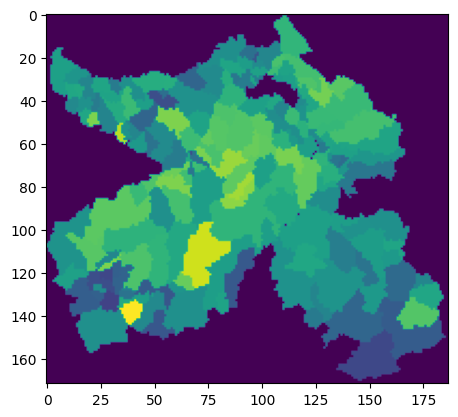

In [ ]:
plt.imshow(image_raw)
plt.show()

In [ ]:
#--------
# parameters
S=16
#--------
model = FDD(Y, X, level = S, lmbda = 100, nu = 0.001, iter = 5000, tol = 5e-5, pick_nu = "kmeans")
u, jumps, J_grid, nrj, eps, it = model.run()

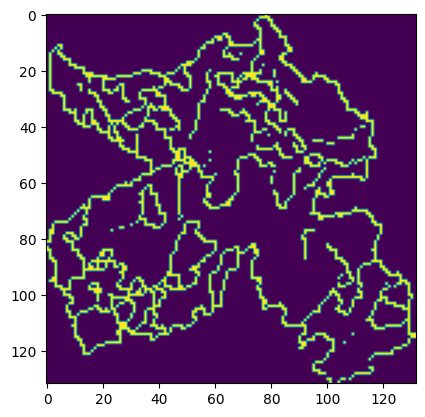

In [ ]:
plt.imshow(J_grid)
plt.show()

## Scattered Microdata 
We can also try to segment the microdata. Dell runs a regression of the individual-level outcomes on a polynomial of the centroid of the district the individual lives in and a dummy for whether the district was a mita. Since we need variation in the spatial location to exploit the microdata, we will instead scatter the individual outcomes randomly throughout the district they belong to. This is more or less equivalent to taking the average centroid as the true location. 

In [ ]:
from shapely.geometry import Point, Polygon
import numpy as np

def random_point_in_shp(shp):
    within = False
    while not within:
        x = np.random.uniform(shp.bounds[0], shp.bounds[2])
        y = np.random.uniform(shp.bounds[1], shp.bounds[3])
        within = shp.contains(Point(x, y))
    return (x,y)



In [ ]:
# create dataframe with N random points per polygon, where N is the individual sample size per district
micro = cons.copy()
micro = cons[['ubigeo', 'desnu']].copy()
micro = micro.merge(height[['geometry','height2_13']].rename(columns = {'height2_13':'ubigeo'}), on ="ubigeo", how = "left")
micro = micro[~micro.geometry.isnull()]
micro[['lon', 'lat']] = micro.apply(lambda x: random_point_in_shp(x.geometry), axis=1, result_type="expand")



In [ ]:
# fill up the background 
temp = height.dissolve()

bbox = gdf.total_bounds
bounding_box_polygon = Polygon([
    (bbox[0], bbox[1]),
    (bbox[0], bbox[3]),
    (bbox[2], bbox[3]),
    (bbox[2], bbox[1])
])
bbox_gdf = gpd.GeoDataFrame({'geometry': [bounding_box_polygon]}, crs=gdf.crs)

temp = gpd.overlay(bbox_gdf, temp, how='difference')

temp = gpd.GeoDataFrame(geometry = temp.geometry.repeat(10000))
temp[['lon', 'lat']] = temp.apply(lambda x: random_point_in_shp(x.geometry), axis=1, result_type="expand")
temp[['desnu', 'ubigeo']] = 0

In [ ]:
micro = pd.concat([micro,temp])

<Axes: >

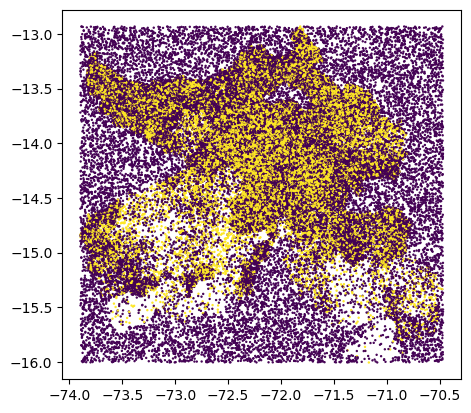

In [ ]:
gdf = gpd.GeoDataFrame(micro, geometry = gpd.points_from_xy(micro.lon, micro.lat), crs = "epsg:4326")
gdf.plot(column = "desnu", s=0.5)

In [ ]:
# segment
Y = np.array(micro['desnu'])
X = np.stack([micro['lat'], micro['lon']], axis = 0).T


#--------
# parameters
S=16
#--------
#model = FDD(Y, X, level = S, lmbda = 1000, nu = 0.01, iter = 10000, tol = 5e-5, pick_nu = "kmeans", qtile = 0.1)
model.nu = 0.001
model.lmbda = 1
u, jumps, J_grid, nrj, eps, it = model.run()

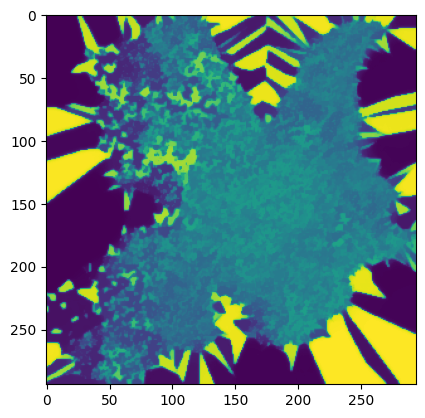

In [ ]:
plt.imshow(u)
plt.show()

In [ ]:
it

8680